# Actividad para evaluación de 3er parcial

Dado lo aprendido a lo largo del semestre durante la materia (python, grafos, interpretación y análisis de conectividad)

El 3er parcial se evaluará a través de la actividad:
__Aplicación y análisis a un dataset__

__Dataset a utilizar__: https://physionet.org/content/eegmmidb/1.0.0/S001/#files-panel

# Rúbrica para evaluación de 3er parcial

Se evaluará:
- Que el script no contenga errores
- Que los resultados del script sean reproducibles, ie que puedan ser reproducibles en cualquier computadora
- El orden del código
- La lógica del código
- La *inferencia* empleada para los parámetros utilizados, tales como thresholds para filtrado de matriz, elección de thresholds para selección de alguna banda específica (alfa, beta, delta, etc.) 
- Los métodos utilizados, ie, si para construir la matriz de conectividad se utilizó coherencia espectral, PLV o correlación, que haya una razón de ello
- Los resultados mostrados, tales como mapas de calor, grafos 2D, grafos 3D, el mostrar comunidades, hubs, nodos proporcionales al grado, filtrado de matriz de
- Conclusión del análisis, ie, al finalizar el análisis dar una conclusión que resuma los resultados encontrados con una interpretación de los mismos
- Que el análisis haya sido aplicado a cada uno de los ensayos/archivos del dataset

In [12]:
import numpy as np
import pandas as pd
import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io as sp
from scipy.io import loadmat
import mne
import glob
import os

In [95]:
#Carga de cada ensayo:
# ensayos= 
# ensay01_excel=r"C:\Users\monce\OneDrive\Documentos\GitHub\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery_Ensayo_01.xlsx"
# ensay02_excel=r"C:\Users\monce\OneDrive\Documentos\GitHub\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery_Ensayo_02.xlsx"
ensay03_excel= r"C:\Users\monce\OneDrive\Documentos\GitHub\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery_Ensayo_03.xlsx"
ensay04_excel= r"C:\Users\monce\OneDrive\Documentos\GitHub\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery_Ensayo_04.xlsx"
# ensay05_excel=r"C:\Users\monce\OneDrive\Documentos\GitHub\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery_Ensayo_05.xlsx"
# ensay06_excel=r"C:\Users\monce\OneDrive\Documentos\GitHub\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery_Ensayo_06.xlsx"

coordenadas=r"C:\Users\monce\OneDrive\Documentos\GitHub\Neurociencias-2026-1\S03_datasets\MI_coordinates.csv"

# ##Los excel van a ser diccionarios
ensayo3_d= pd.read_excel(ensay03_excel, sheet_name=None, index_col=0) ##agarrar los mismos indíces del excel
ensayo04_d= pd.read_excel(ensay04_excel, sheet_name=None, index_col=0)
# ensayo05_d=
# ensayo06_d=
# ensayo07_d=
# ensayo08_d=
# ensayo09_d=
# ensayo010_d=
# ensayo011_d=
# ensayo013_d=
# ensayo014_d=


In [97]:
# def lista_dfs (ensayo_dict):
#     ensayos_dfs=[] 
#     for sujeto in  ensayo3_d.keys():
#         ensayos_dfs.append( ensayo_dict[sujeto])
#     return ensayos_dfs
ensayo3= lista_dfs(ensayo3_d)
ensayo4=lista_dfs(ensayo04_d)

In [102]:
##Filtrado de matrices, apilación
# 
# def capsula (list_df, th, porcentaje_):
#     stack=np.stack([df.values for df in list_df]) ##esto solo apila
#     above= stack> th
#     N= len(list_df)
#     contar= above.sum(axis=0) ##aquí estamos contando cuantos valores superan el umbral en cada celda
    
#     min_requerido= int(np.ceil(porcentaje_*N)) 
#     resultado_boleano= contar>= min_requerido
    
#     result_df= pd.DataFrame(resultado_boleano, index=list_df[0].index, columns= list_df[0].columns).astype(int)
#     return result_df
# #Con esto bastará con quedarnos con las celdas de abova que cumplan con el min requerido, para así tener el número de sujeto que superan el umbral. 
# #esto dice: cada celca tendrá un 1 si al menos 60% de los sujetos cumplierón con el umbral, si la celca es 0, significa que menos del 60% de los sujetos
# #cumplierón con el umbral

resultados3=capsula(ensayo3, 0.3, 0.6)
resultados=capsula(ensayo4, 0.3, 0.6)


ValueError: Input could not be cast to an at-least-1D NumPy array

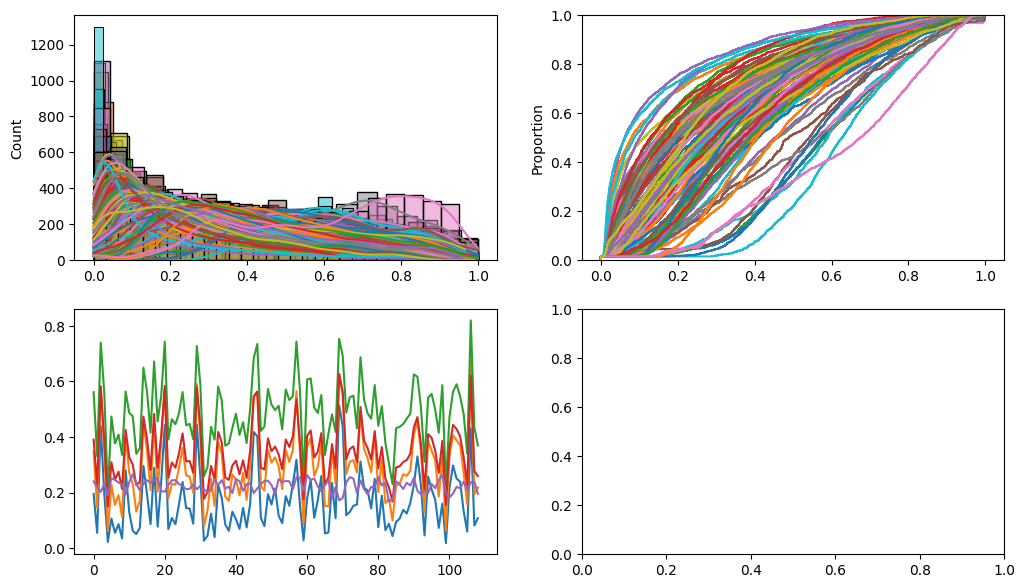

In [43]:
##Calcular estadísticos para decidir umbrales:
t25, t50, t75, promedio, varianza= [],[],[],[],[]
mu_sigm=[]
fig, axes= plt.subplots(2,2, figsize=(12,7))
for sujeto in ensayos3_dfs:
    data=sujeto.stack().values
    t25.append(np.percentile(data, 25))
    t50.append(np.percentile(data,50))
    t75.append(np.percentile(data,75))
    promedio.append(np.mean(data))
    varianza.append(np.std(data))
    mu_sigm.append(promedio+varianza)
    #plots
    sns.histplot(sujeto.stack().values, ax=axes[0][0], kde=True) ##kde es para la distribución, stack es para aplanar
    sns.ecdfplot(sujeto.stack().values, ax=axes[0][1]) ##distribución acumulada
axes[1][0].plot(t25, label="percentile 25")
axes[1][0].plot(t50, label="percentile 25")
axes[1][0].plot(t75, label="percentile 25")
axes[1][0].plot(promedio, label="percentile 25")
axes[1][0].plot(varianza, label="percentile 25")
axes[1][0].plot(mu_sigm, label="percentile 25")

    

In [44]:
data= pd.DataFrame(columns=["t25", "t50", "t75", "promedio", "varianza"], index=["min", "max", "media", "percentil30","mediana"])
columnas=[t25, t50, t75, promedio, varianza]
minimos=[]
maximos=[]
media=[]
perc30=[]
mediana=[]
cosa=[]
for lista in columnas:
    a=min(lista)
    minimos.append(a)
    b=max(lista)
    maximos.append(b)
    medias= np.mean(lista)
    media.append(medias)
    perc=np.percentile(lista, 30)
    perc30.append(perc)
    m=np.median(lista)
    mediana.append(m)

data.loc["min"]=minimos
data.loc["max"]=maximos
data.loc["media"]=media
data.loc["percentil30"]=perc30
data.loc["mediana"]=mediana
data

,t25,t50,t75,promedio,varianza
min,0.018413,0.06175,0.196867,0.149821,0.16782
max,0.514472,0.674805,0.819681,0.626848,0.266529
media,0.166961,0.295352,0.489628,0.345504,0.224412
percentil30,0.089118,0.220086,0.432409,0.28858,0.212498
mediana,0.144574,0.273808,0.484181,0.3277,0.227821


In [ ]:
##Función más cool del profe
for columna in data
  

Text(0.5, 1.0, 'umbral=0.2, 0.3, 0.5, y 0.6, población>60%')

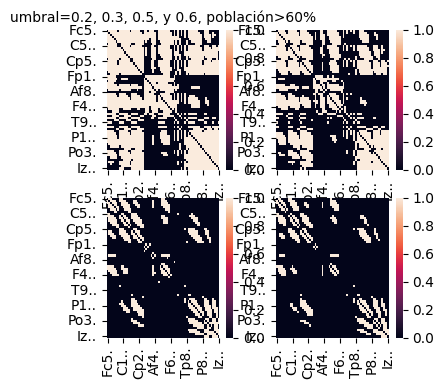

In [45]:
##Mapas de calor con distintos umbral
resultados1=capsula(ensayos3_dfs, 0.2, 0.6)
resultados2=capsula(ensayos3_dfs, 0.3, 0.6)
resultados3=capsula(ensayos3_dfs, 0.55, 0.6)
resultados4=capsula(ensayos3_dfs, 0.6, 0.6)


fig,axes= plt.subplots(2,2, figsize=(4,4))
sns.heatmap(resultados1, ax=axes [0,0])
sns.heatmap(resultados2, ax=axes [0,1])
sns.heatmap(resultados3, ax=axes [1,0])
sns.heatmap(resultados4, ax=axes [1,1])
axes[0,0].set_title("umbral=0.2, 0.3, 0.5, y 0.6, población>60%", fontsize=10)

Text(0.5, 1.0, 'umbral=0.2, 0.3, 0.5, y 0.6, población>60%')

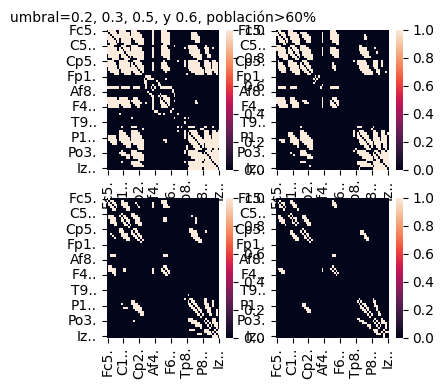

In [46]:
# resultados1=capsula(ensayos3_dfs, 0.2, 0.9)
# resultados2=capsula(ensayos3_dfs, 0.3, 0.9)
# resultados3=capsula(ensayos3_dfs, 0.5, 0.9)
# resultados4=capsula(ensayos3_dfs, 0.6, 0.9
#                    )


# fig,axes= plt.subplots(2,2, figsize=(4,4))
# sns.heatmap(resultados1, ax=axes [0,0])
# sns.heatmap(resultados2, ax=axes [0,1])
# sns.heatmap(resultados3, ax=axes [1,0])
# sns.heatmap(resultados4, ax=axes [1,1])
# axes[0,0].set_title("umbral=0.2, 0.3, 0.5, y 0.6, población>60%", fontsize=10)

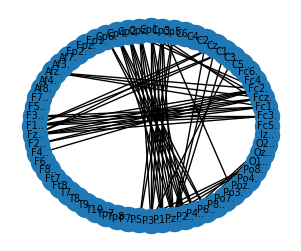

In [80]:
# ## Grafo 2D
# def grado_2d (resultados, pos):
#     ensayo_grafo=nx.from_pandas_adjacency(resultados3)
#     nx.draw_circular(ensayo_grafo, with_labels=True, font_size=7, ax=pos)
#     return ensayo_grafo
# fig = plt.figure(figsize=(8,3))
# axes=[fig.add_subplot(1,2,1)]
# ensayo=grado_2d (resultados3, axes[0])

In [103]:


ensayo3_grafo=nx.from_pandas_adjacency (resultados3)
ensayo4_grafo=nx.from_pandas_adjacency (resultados4)

In [48]:
def metricas (G):
    clust= nx.average_clustering(G)
    try:
        path_length= nx.average_shortest_path_length(G)
    except nx.NetworkXError:
        path_length=np.nan
    #grafo aleatorio
    G_rand=nx.gnm_random_graph(n=G.number_of_nodes(), m=G.number_of_edges())
    clust_rand=nx.average_clustering(G_rand)
    path_rand=nx.average_shortest_path_length(G_rand)
    small_world_sigma= (clust/clust_rand)/ (path_length/path_rand)
    #Modularidad
    from networkx.algorithms import community
    communities= community.greedy_modularity_communities(G)
    modularity= community.modularity(G, communities)
    #HUBS
    degree_dict= dict(G.degree())
    betwenness=nx.betweenness_centrality(G)
    betwenness=sorted(betwenness.items(), key=lambda x:x[1], reverse=True)
    #Eficiencia globaly local
    global_eff= nx.global_efficiency(G)
    local_eff=nx.local_efficiency(G)
    print("metricas de grafo")

    return (clust,path_length, small_world_sigma,communities,modularity,betwenness,global_eff, local_eff, degree_dict)
metricas(ensayo_grafo)   
    

metricas de grafo


(0.4020645153457654,
 nan,
 nan,
 [frozenset({'Afz.',
             'C1..',
             'C2..',
             'C4..',
             'C6..',
             'Cz..',
             'F1..',
             'F2..',
             'F3..',
             'F4..',
             'Fc1.',
             'Fc2.',
             'Fc3.',
             'Fc4.',
             'Fc5.',
             'Fcz.',
             'Fz..'}),
  frozenset({'C3..',
             'C5..',
             'Cp1.',
             'Cp3.',
             'Cp5.',
             'Cpz.',
             'O1..',
             'Oz..',
             'P1..',
             'P3..',
             'P5..',
             'P7..',
             'Po3.',
             'Po7.',
             'Poz.',
             'Pz..',
             'Tp7.'}),
  frozenset({'Cp2.',
             'Cp4.',
             'Cp6.',
             'Iz..',
             'O2..',
             'P2..',
             'P4..',
             'P6..',
             'P8..',
             'Po4.',
             'Po8.'}),
  frozenset({'Fc

In [105]:
#Guardar 
(clust_3,path_length_3, small_world_sigma_3,communities_3,modularity_3,betwenness_3,global_eff_3, local_eff_3, degree_dict_3)=metricas(ensayo3_grafo)
(clust_,path_length_4, small_world_sigma_4,communities_4,modularity_4,betwenness_4,global_eff_4, local_eff_4, degree_dict_4)=metricas(ensayo4_grafo)


metricas de grafo


NetworkXError: Graph is not connected.

In [50]:
coord= pd.read_csv(coordenadas)
coord.set_index("canal", drop=True, inplace=True)
coord

,x,y,z
canal,,,
Fc5.,-0.5731,0.2666,0.7748
Fc3.,-0.3502,0.4036,0.8454
Fc1.,-0.1209,0.4740,0.8718
Fcz.,0.0000,0.5147,0.8574
Fc2.,0.1209,0.4740,0.8718
...,...,...,...
Po8.,0.7210,-0.5570,0.4110
O1..,-0.3090,-0.8090,0.5000
Oz..,0.0000,-0.8500,0.5266


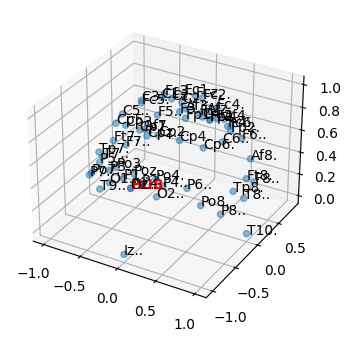

In [72]:
x,y,z= coord["x"],coord["y"].values, coord["z"].values
hub= betwenness_[0]

def grafo_3d (Hub, coords, pos):
    x,y,z= coords["x"],coord["y"].values, coords["z"].values

    nodes_size=[30 if idx !=Hub[0] else 200 for idx in coords.index]
    pos.scatter(x,y,z, alpha=0.5)
    for idx, (x_,y_,z_) in enumerate(zip(x,y,z)):
        pos.text(x_,y_,z_,coords.index[idx], fontsize=10)
        if coords.index[idx]== Hub[0]:
            pos.text(x_,y_,z_,"HUB", color="red", fontweight="bold", fontsize=10)
fig = plt.figure(figsize=(4,4))
axes=[fig.add_subplot(1,1,1, projection="3d")]
    
grafo_3d (hub, coord, axes[0])

In [ ]:
##Agregar comunidades
#grafo 2d
#grafo 3d y grafos de comunidades por ensayo 3d, hacer for por las comunidades

In [53]:
comunidad_prueba = communities_[2]
n1, n2 = list(comunidad_prueba)[0], list(comunidad_prueba)[1]
n1, n2

('Cp4.', 'Iz..')

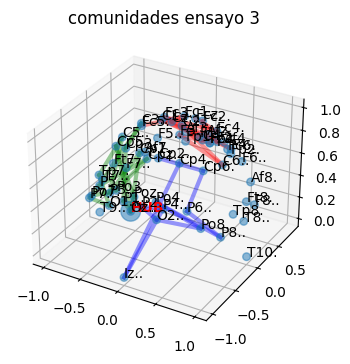

In [68]:
## grafo de comunidades

hub = betwenness_[0]

fig = plt.figure(figsize=(4, 4))
axes = [fig.add_subplot(1, 1, 1, projection='3d')]

def grafo_de_comunidades(comunidades, Hub, coords, pos):
    x, y, z = coords['x'].values, coord['y'].values, coords['z'].values
    nodes_size = [30 if idx != Hub[0] else 200 for idx in coords.index]
    pos.scatter(x, y, z, alpha=0.5, s=nodes_size)
    for idx, (x_, y_, z_) in enumerate(zip(x, y, z)):
        pos.text(x_, y_, z_, coords.index[idx], fontsize=10)
        if coords.index[idx] == Hub[0]:
            pos.text(x_, y_, z_, 'HUB', color='red', fontweight='bold', fontsize=10)
    
    colores = ['red','green','blue','black','orange']
    for n_comunidad, comunidad in enumerate (comunidades):
        for idx in range(len(comunidad)-1):
            n1, n2= list(comunidad)[idx], list(comunidad)[idx+1]
            x_=[coords.loc[n1,'x'], coords.loc[n2,'x']]
            y_=[coords.loc[n1,'y'], coords.loc[n2,'y']]
            z_=[coord.loc[n1,'z'], coords.loc[n2,'z']]
            pos.plot(x_,y_,z_, linewidth=3, alpha=0.4, color=colores[n_comunidad])
    pos.set_title('comunidades ensayo 3')
grafo_de_comunidades(communities_, hub, coord, axes[0])

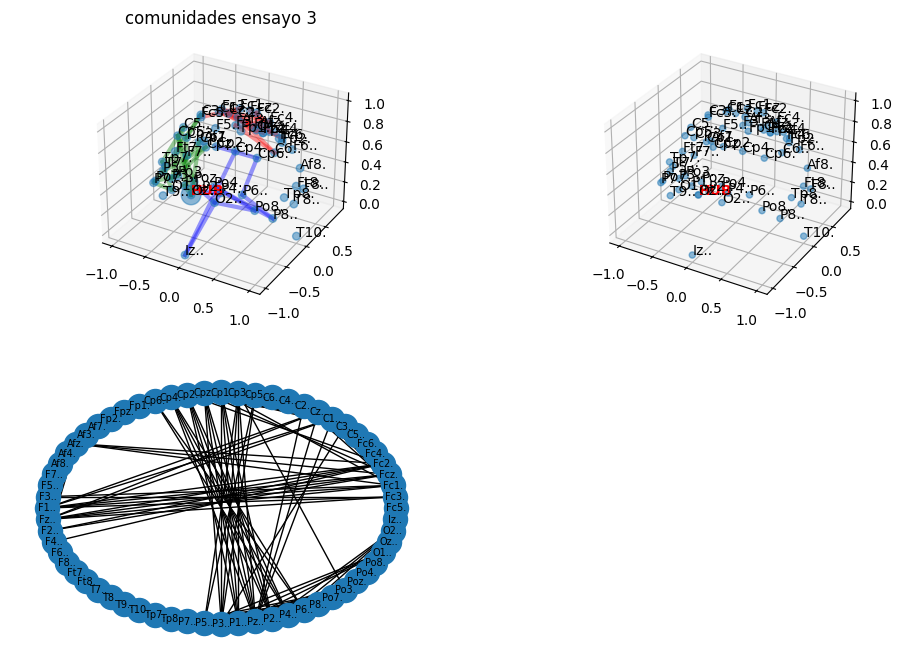

In [85]:
#Encapsular código, 
hub = betwenness_[0]

fig = plt.figure(figsize=(12, 8))
axes = [fig.add_subplot(2, 2, 1, projection='3d'),
       fig.add_subplot(2, 2, 2, projection='3d'),
       fig.add_subplot(2,2,3)]
        

grafo_de_comunidades(communities_, hub, coord, axes[0])
grafo_3d (hub, coord, axes[1])
ensayo=grado_2d (resultados3, axes[2])